In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy import stats
import pandas as pd
from scipy import fftpack

1\. **Hurricanes per Year**

The number of hurricanes in 2005 was 15. The historic average is 6.3. Is this number signficantly different?
- Assume the number of hurricanes is random, i.e. follows the Poisson distribution.
- Assume as statistically significant a probability that has a Z score of 3 or larger with respect a normal distribution.

**Hint**: compute the probability that in a single year are observed 15 or more hurricances.

Z = 3.47

If we assume as statistically significant a probability that has a Z score of 3 or larger with respect a normal distribution, 15 hurricanes is significantly differnt. 

p-value =  0.0005

The probability of observing 15 or more hurricances in a single year is: 0.0008


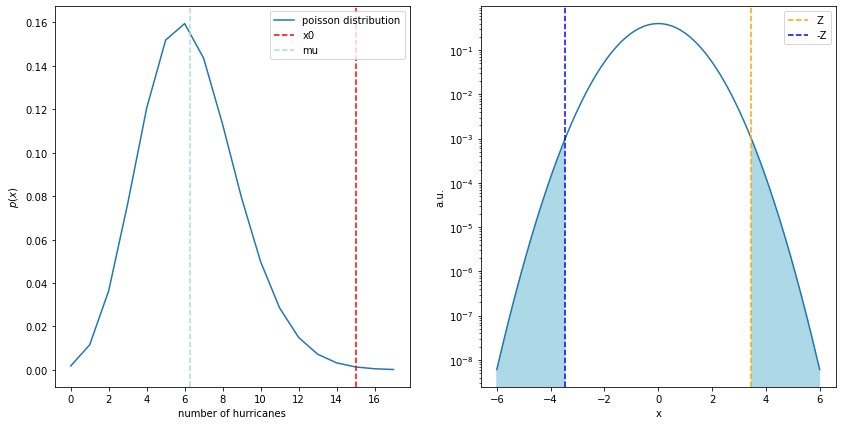

In [8]:
x0 = 15.
mu = 6.3
sigma = math.sqrt(mu)


Z = abs(x0 - mu) / sigma
print("Z = {:.2f}\n".format(Z))
print("If we assume as statistically significant a probability that has a Z score of 3 or larger with respect a normal distribution, 15 hurricanes is significantly differnt. \n")

w = abs(mu - x0)
x = np.arange(0, w + mu +sigma, 1, dtype='int')
y = stats.poisson.pmf(x, mu, loc=0)

fig, (ax1,ax2)=plt.subplots(nrows=1, ncols=2, figsize=(14,7))

ax1.plot(x, y, label='poisson distribution')
ax1.axvline(x0, linestyle='--', color='red', label='x0')
ax1.axvline(mu, linestyle='--', color='lightblue', label='mu')
ax1.set_ylabel("$p(x)$")
ax1.set_xlabel("number of hurricanes")
ax1.legend(loc='upper right')
ax1.set_xticks(np.arange(0,18,2))

xs = np.linspace(-6, +6, 1000)
ts = stats.norm.pdf(xs)
ax2.plot(xs, ts)
ax2.fill_between(xs, ts, where=np.abs(xs) > np.abs(Z), color='lightblue')
ax2.axvline(Z, linestyle='--', color='orange', label="Z")
ax2.axvline(-Z, linestyle='--', color='blue', label="-Z")
ax2.set_ylabel("a.u.")
ax2.set_xlabel("x")
ax2.set_yscale("log")
ax2.legend()


pvalue = stats.norm.cdf(-Z) + (1. - stats.norm.cdf(Z))

prob=1-stats.poisson.cdf(x0,mu)

print("p-value =  {:.4f}\n".format(pvalue))
print("The probability of observing 15 or more hurricances in a single year is: {:.4f}".format(prob))

## 2\. **Pairwise t-test**

In an experiment, a group of 10 individuals agreed to participate in a study of blood pressure changes following exposure to halogen lighting. Resting systolic blood pressure was recorded for each individual. The participants were then exposed to 20 minutes in a room lit only by halogen lamps. A post-exposure systolic blood pressure reading was recorded for each individual. The results are presented in the following data set:

```python
pre = np.array([120, 132, 120, 110, 115, 128, 120, 112, 110, 100])
post = np.array([140, 156, 145, 130, 117, 148, 137, 119, 127, 135])
```

Determine whether the change in blood pressures within our sample was statistically significant.

**Hint:**
in this case, the Student's $t$-test should be performed to compare the two datasets.
Use the following test statistics:

$$T = \frac{\bar{x}_1 - \bar{x}_2}{\sigma \sqrt{\frac{2}{n}}}$$

and 

$$\sigma = \sqrt{\frac{\sigma_1^2 + \sigma_2^2}{2}}$$

T = 3.79

p-value = 0.0043

If we assume the significance level = 0.05 we reject the null hypothesis because the p-value is below it, so we can conclude that the change in blood pressures within our sample is statistically significant.


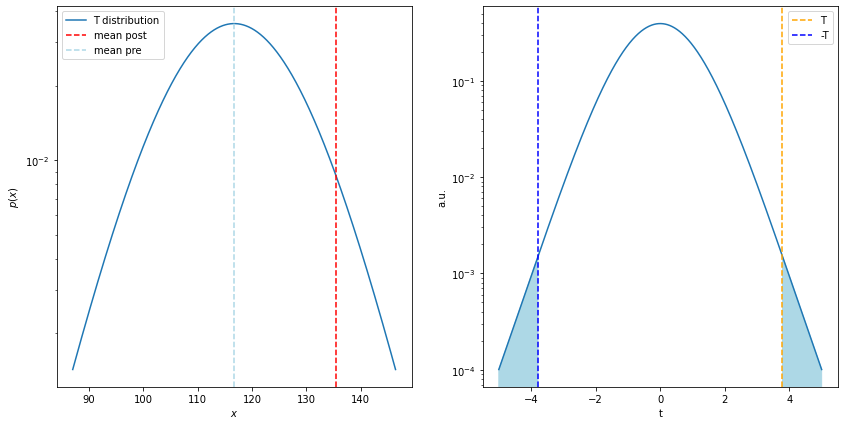

In [9]:
pre = np.array([120, 132, 120, 110, 115, 128, 120, 112, 110, 100])
post = np.array([140, 156, 145, 130, 117, 148, 137, 119, 127, 135])

n=len(pre)
mu1=pre.mean()
mu2=post.mean()
sigma=math.sqrt((pre.var(ddof=1)+post.var(ddof=1))/2)
T=(mu2-mu1)/(sigma*math.sqrt(2/n))
print("T = {:.2f}\n".format(T))


fig, (ax1,ax2)=plt.subplots(nrows=1, ncols=2, figsize=(14,7))


w = mu2 - mu1
x = np.linspace(mu1 - w - sigma, w + mu1 + sigma, 1000)
y = stats.t.pdf(x, loc=mu1, scale=sigma, df=2*n - 2)
ax1.plot(x, y, label="T distribution")
ax1.axvline(mu2, linestyle='--', color='red', label="mean post")
ax1.axvline(mu1, linestyle='--', color='lightblue', label="mean pre")
ax1.set_ylabel("$p(x)$")
ax1.set_xlabel("$x$")
ax1.set_yscale("log")
ax1.legend()

xs = np.linspace(-5, +5, 1000)
ts = stats.t.pdf(xs, 2*n - 2)
ax2.plot(xs, ts)
ax2.fill_between(xs, ts, where=np.abs(xs) > np.abs(T), color='lightblue')
ax2.axvline(T, linestyle='--', color='orange', label="T")
ax2.axvline(-T, linestyle='--', color='blue', label="-T")
ax2.set_ylabel("a.u.")
ax2.set_xlabel("t")
ax2.set_yscale("log")
ax2.legend()


pvalue = stats.t.cdf(-T, n - 1) + (1. - stats.t.cdf(T, n - 1))
print("p-value = {:.4f}\n".format(pvalue))
print("If we assume the significance level = 0.05 we reject the null hypothesis because the p-value is below it, so we can conclude that the change in blood pressures within our sample is statistically significant.")

3\. **FFT of a simple dataset**

Perform a periodicity analysis on the lynxs-hares population, i.e. determine what is the period of the population of these animals.

Peak period for the lynxes population: 10.5
Peak period for the hares population: 10.5


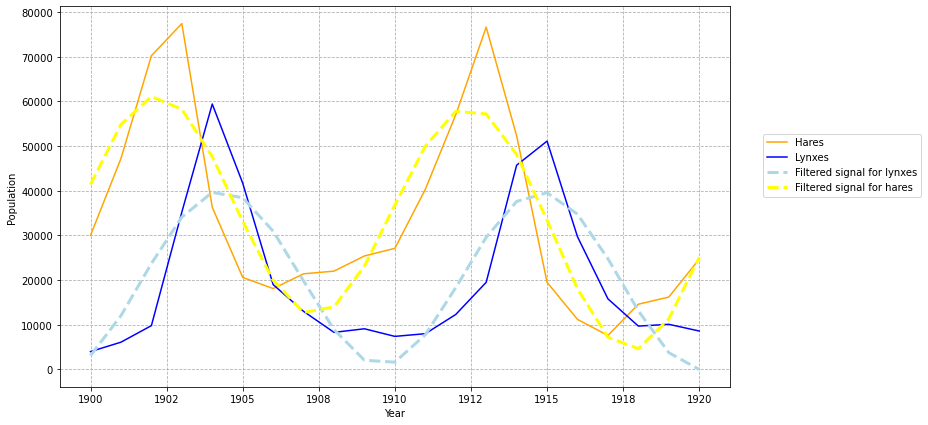

In [4]:
from matplotlib.ticker import FormatStrFormatter

data = np.loadtxt('populations.txt')
year, hares, lynxes, carrots = data.T

time_size=1.

l_fft = fftpack.fft(lynxes)
l_power = np.abs(l_fft)
l_sample_freq = fftpack.fftfreq(lynxes.size, d=time_size)
l_pos_mask = np.where(l_sample_freq > 0)
l_freqs = l_sample_freq[l_pos_mask]
l_powes = l_power[l_pos_mask]
print("Peak period for the lynxes population:", 1/l_freqs[l_powes.argmax()])

h_fft = fftpack.fft(hares)
h_power = np.abs(h_fft)
h_sample_freq = fftpack.fftfreq(hares.size, d=time_size)
h_pos_mask = np.where(h_sample_freq > 0)
h_freqs = h_sample_freq[h_pos_mask]
h_powes = h_power[h_pos_mask]
print("Peak period for the hares population:", 1/h_freqs[h_powes.argmax()])

#as expected they are quite similar

l_high_freq_fft = l_fft.copy()
l_high_freq_fft[np.abs(l_sample_freq) > l_freqs[l_powes.argmax()]] = 0
l_filtered_sig = fftpack.ifft(l_high_freq_fft)
l_real_filtered_signal = np.real(l_filtered_sig)

h_high_freq_fft = h_fft.copy()
h_high_freq_fft[np.abs(h_sample_freq) > h_freqs[l_powes.argmax()]] = 0
h_filtered_sig = fftpack.ifft(h_high_freq_fft)
h_real_filtered_signal = np.real(h_filtered_sig)


year=year.round(0)
fig, ax=plt.subplots(figsize=(12,7))
ax.plot(year, hares, c='orange', label='Hares')
ax.plot(year, lynxes, c='blue', label='Lynxes')
ax.plot(year, l_real_filtered_signal, linewidth=3, c='lightblue', ls='--', label='Filtered signal for lynxes')
ax.plot(year, h_real_filtered_signal, linewidth=3, c='yellow', ls='--', label='Filtered signal for hares')
ax.legend(loc=(1.05, 0.5)) 
ax.set_xlabel('Year')
ax.set_ylabel("Population")
ax.xaxis.set_major_formatter(FormatStrFormatter('%.0f'))
ax.grid(ls='--')

4\. **FFT of an image**

Write a filter that removes the periodic noise from the `moonlanding.png` image by using a 2-dimensional FFT.

* Import the image as a 2D numpy array using `plt.imread("moonlanding.png")`. Examine the image with `plt.imshow()`, which is heavily contaminated with periodic noise.
* Check the documentation of the `scipy.fftpack` package, and find the method that performs a 2D FFT. Plot the spectrum (Fourier transform of) the image. **Hint**: use `LogNorm` to plot the colors in log scale:
```Python
from matplotlib.colors import LogNorm
plt.imshow(image, norm=LogNorm(vmin=5))
```
* Inspect the spectrum, and try to locate the regions of the power spectrum that contain the signal and those which contain the periodic noise. Use array slicing to set the noise regions to zero.
* Apply the inverse Fourier transform to plot the resulting image.

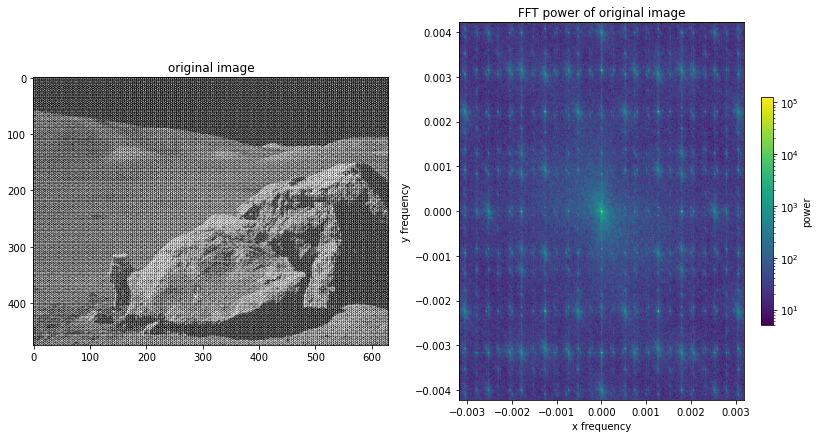

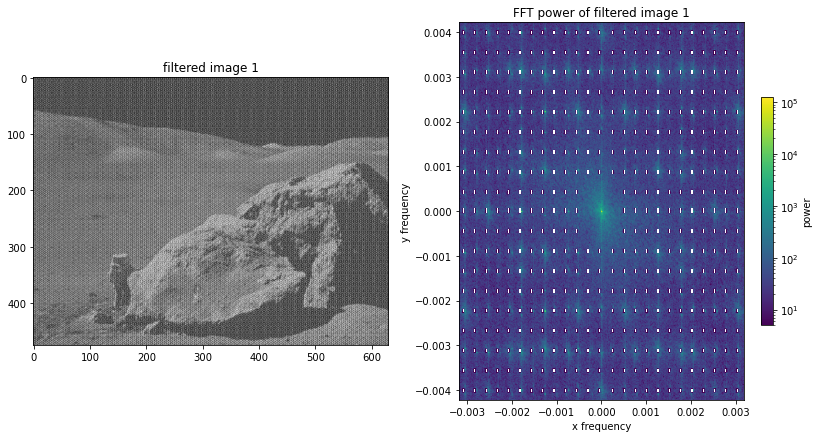

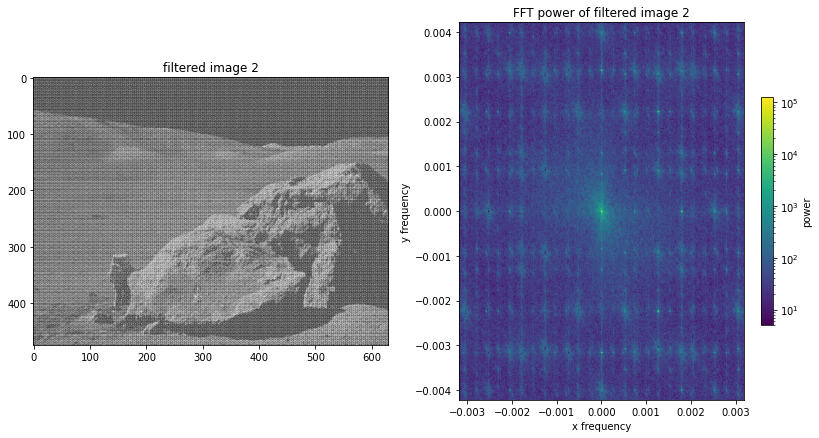

In [15]:
from matplotlib.colors import LogNorm
import matplotlib.image as mpimg
#1
fig, (ax1,ax2)=plt.subplots(nrows=1, ncols=2, figsize=(14,14))

image = mpimg.imread("moonlanding.png")
ax1.imshow(image, plt.cm.gray)
ax1.set_title("original image")
M, N = image.shape

#2
fft = fftpack.fft2(image)
powerabs = np.abs(fft)
powerabs = fftpack.fftshift(powerabs) #shift the zero-frequency component to the center of the spectrum.
c=ax2.imshow(powerabs, norm=LogNorm(vmin=5), extent=(-1/(N//2), 1 /(N//2), -1/(M//2), 1 /(M//2)))
fig.colorbar(c,ax=ax2, shrink=0.3, label='power')
ax2.set_xlabel('x frequency')
ax2.set_ylabel('y frequency')
ax2.set_title("FFT power of original image")

fft1=fft.copy()
fft2=fft.copy()

#3_a
d=3
r=np.arange(50,M-25,25)
c=np.arange(50,N-35,25)

for n1 in r:
    for n2 in c:
        fft[n1-d:n1+d,n2-d:n2+d]=0
        
for n2 in c:
    fft[0:d,n2-d:n2+d]=0
    fft[25-d:25+d,n2-d:n2+d]=0
    fft[450-d:450+d,n2-d:n2+d]=0
    fft[473-d:,n2-d:n2+d]=0
    
for n1 in r:
    fft[n1-d:n1+d, 0:d//2]=0
    fft[n1-d:n1+d, 25-d:25+d]=0
    fft[n1-d:n1+d, 600-d:600+d]=0
    fft[n1-d:n1+d, 625-d:625+d]=0

#4_a
filt_image = np.real(fftpack.ifft2(fft))

powercop=np.abs(fft) 
powercop=fftpack.fftshift(powercop) #shift the zero-frequency component to the center of the spectrum.

fig1, (ax3, ax4) = plt.subplots(nrows=1, ncols=2, figsize=(14,14))
ax3.imshow(filt_image, plt.cm.gray)
ax3.set_title("filtered image 1")
c1=ax4.imshow(powercop, norm=LogNorm(vmin=5), extent=(-1/(N//2), 1 /(N//2), -1/(M//2), 1 /(M//2)))
fig.colorbar(c1,ax=ax4, shrink=0.3, label='power')
ax4.set_xlabel('x frequency')
ax4.set_ylabel('y frequency')
ax4.set_title("FFT power of filtered image 1");

#alternative method without slicing    
#3_b
K=50

fft1[: K, : K] = 0
fft1[: K, N-K: ] = 0
fft1[M-K: , : K] = 0
fft1[M-K: , N-K: ] = 0

fft1[np.abs(fft) > 300]=0  #choose 300 as the min power to be filtered, except for low frequencies that are not filtered

fft1[: K, : K] = fft2[: K, : K]
fft1[: K, N-K: ] = fft2[: K, N-K: ]
fft1[M-K: , : K] = fft2[M-K: , : K]
fft1[M-K: , N-K: ] = fft2[M-K: , N-K: ]

#4_b
filt_image = np.real(fftpack.ifft2(fft1))

powercop=np.abs(fft1) 
powercop=fftpack.fftshift(powercop) #shift the zero-frequency component to the center of the spectrum.

fig2, (ax5, ax6) = plt.subplots(nrows=1, ncols=2, figsize=(14,14))
ax5.imshow(filt_image, plt.cm.gray)
ax5.set_title("filtered image 2")
c1=ax6.imshow(powercop, norm=LogNorm(vmin=5), extent=(-1/(N//2), 1 /(N//2), -1/(M//2), 1 /(M//2)))
fig.colorbar(c1,ax=ax6, shrink=0.3, label='power')
ax6.set_xlabel('x frequency')
ax6.set_ylabel('y frequency')
ax6.set_title("FFT power of filtered image 2");


